# Lab 10: Classification Forests
Welcome to the tenth DS102 lab! 

The goals of this lab is to implement and gain a hands on understanding of classification tree and forests.
The code you need to write is commented out with a message "TODO: fill in". There is additional documentation for each part as you go along.


## Course Policies

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

**Submission**: to submit this assignment, rerun the notebook from scratch (by selecting Kernel > Restart & Run all), and then print as a pdf (File > download as > pdf) and submit it to Gradescope.


**This assignment should be completed and submitted before Tuesday November 26, 2019 at 11:59 PM.** 

In [1]:
%pylab inline
import matplotlib.pyplot as plt

import numpy as np
import sklearn

from sklearn import datasets, metrics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

Populating the interactive namespace from numpy and matplotlib


# Part 1: Download the Data and Separate a Holdout Set 

In this lab, we will classify images of handwritten digits using classification trees and forests. First, we need to download the dataset of images of handwritten digits, matched with the label of the digit.

Download the digits dataset from sklearn.datasets.load_digits(). Before doing any visualization or model training, separate a holdout set of 20% of the data drawn i.i.d. from the full dataset. Put the remaining instances in the training set. 

In [2]:
# download the dataset
digits = datasets.load_digits()
# total number of image - label instances
n = len(digits['data'])

# split into training set and holdout set.
frac_holdout = .20

rs = np.random.RandomState(0)
n_holdout = int(n*frac_holdout)

# randomly shuffle indices, then use the lat n_holdout instances for the holdout set
random_idxs = rs.choice(n,n, replace=False)
train_set_idxs = random_idxs[:-n_holdout]
holdout_set_idxs = random_idxs[-n_holdout:]

X_train = digits['data'][train_set_idxs]
y_train = digits['target'][train_set_idxs]



## Visualize the data
Now, visualize the training set data. For each class in [0,...,9], plot 3 images corresponding to images for that class.

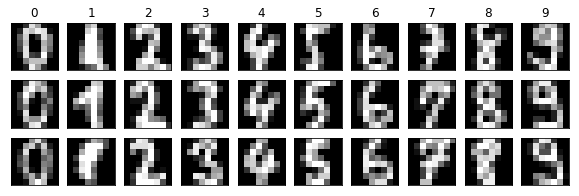

In [3]:
# show a few training set image from each class
num_from_each_class = 3
fig, ax = plt.subplots(num_from_each_class,10,figsize=(10,3))
for i in range(10):
    ax[0,i].set_title('{0}'.format(i))
    ids_with_label_i = np.where(y_train == i)[0]
    
    for j in range(num_from_each_class):
        ax[j,i].imshow(X_train[ids_with_label_i[j]].reshape(8,8), cmap='gray')
        ax[j,i].set_xticks([]), ax[j,i].set_yticks([])

# Part 2: Training a Classification Tree.

Now we're ready to learn a predictor of the labels for each image, given instances from the training set. We'll use 5-fold cross validation on the training set to separate 5 train-validation set splits.  

Fill in the function below to train the classication tree. Note that a tree is just a forest with only one estimator.

In [4]:
# perform k-fold validation on the training set.
def train_and_evaluate_tree(X, y, max_depths, num_folds=5):
    # returns the per-fold validation accuracies for each setting of max_depths
    kf = KFold(n_splits=num_folds)

    tree_accs_by_fold = np.zeros((num_folds, len(max_depths)))
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]

        for j, depth in enumerate(max_depths):
            # fit_random_forest_classifier
            # a tree is just a forest with one tree
            clf = RandomForestClassifier(n_estimators=1, 
                                     max_depth=depth,
                                     random_state=0)
            # Fit the random tree
            clf.fit(X_train, y_train)    
            # predict using the fitted tree
            y_val_pred = clf.predict(X_val)
        
            # store accuracy for this fold and hyperparameter setting.
            tree_accs_by_fold[i,j] = metrics.accuracy_score(y_val, y_val_pred)
            
    return tree_accs_by_fold


# TODO: train a single tree with max_depth 5
print(train_and_evaluate_tree(X_train, y_train, max_depths= [5]))

[[0.62152778]
 [0.51388889]
 [0.63194444]
 [0.73519164]
 [0.63414634]]


Now, we'll investigate how the accuracy of our classifier varies as we increase the complexity of the tree. 
In the cell below, compute the accuracies for 5-folds with the following max_depth settings: 1,2,4,8,16,32.

In [5]:
# plot performance as a function of depth of the tree
max_depths = [1,2,4,8,16,32]
accs_tree_by_depth = train_and_evaluate_tree(X_train, y_train, max_depths= max_depths)

Now for each hyperparameters setting, plot the average, min, and max accuracy over the 5 folds.

Text(0, 0.5, 'validation set accuracies')

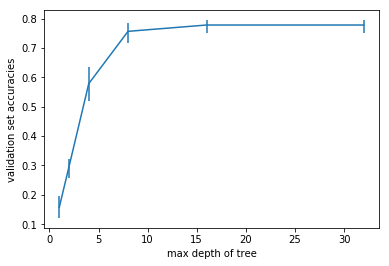

In [6]:
# find the average, min, and max per-fold performance over all max_depth settings
avgs_by_depth = np.average(accs_tree_by_depth, axis=0)
mins_by_depth = np.min(accs_tree_by_depth, axis=0)
maxs_by_depth = np.max(accs_tree_by_depth, axis=0)


y_bounds_by_depth =  np.vstack((avgs_by_depth - mins_by_depth, maxs_by_depth - avgs_by_depth))                   
plt.errorbar(x = max_depths,
             y = avgs_by_depth,
             yerr = y_bounds_by_depth)

plt.xlabel('max depth of tree')
plt.ylabel('validation set accuracies')

TODO: What do you notice about the dependence of accuracy on the depth of the tree? What about the variation across folds? Is this what you expected?

# Part 3: Training Classification Forests

Now we'll train classification forests with many trees. Fill in the following function to run k-fold cross validation to report the accuracy of different hyperparameters settings on the validation sets. Your implementation should look similar to the train_and_evaluate_tree() function above, where now we also loop over the number of trees in the forest as an additional hyperparameter.

In [7]:
def train_and_evaluate_forest(X, y, max_depths, num_trees, num_folds=5):
    # returns the per-fold validation accuracies for each setting of max_depths and num_trees

    accs_by_fold = np.zeros((num_folds, len(num_trees), len(depths)))

    kf = KFold(n_splits=num_folds)
    
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        print("on fold {0} of {1}".format(i, num_folds))
        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]

        for j, num_tree in enumerate(num_trees):
            for k, depth in enumerate(max_depths):
                # fit_random_forest_classifier
                clf = RandomForestClassifier(n_estimators= num_tree, 
                                         max_depth=depth,
                                         random_state=0)
    
                clf.fit(X_train, y_train)    
                y_val_pred = clf.predict(X_val)
                accs_by_fold[i,j,k] = metrics.accuracy_score(y_val, y_val_pred)
                
    return accs_by_fold

In [8]:
# Evaluate the random forest classifier with the following hyperparameters
num_trees = [1,10,20,50,100,200,400]
depths = [2, 4, 8]

accs_by_fold_forest = train_and_evaluate_forest(X_train, y_train,
                                                    max_depths = depths,
                                                    num_trees = num_trees)

on fold 0 of 5
on fold 1 of 5
on fold 2 of 5
on fold 3 of 5
on fold 4 of 5


Plot the performance of the random forest as a function of the number of trees in the forest. Specifically, 
for each setting of num_trees, plot the average validation set accuracy across folds for the setting of max_depths which maximizes this accuracy.

In [9]:
# first take the average over folds
accs_avged_by_fold = np.average(accs_by_fold_forest,axis=0)
# then, for each setting of num_trees, maximize over the settings of max_depth
accs_by_num_trees = np.max(accs_avged_by_fold, axis=1)

In [18]:
#report the setting of max_depth which maximizes the average per-fold accuracy, for each setting of num_trees.
best_idxs_of_depths = np.argmax(accs_avged_by_fold, axis=1)
best_depths_by_num_trees = [depths[idx] for idx in best_idxs_of_depths]
print(best_depths_by_num_trees)

[8, 8, 8, 8, 8, 8, 8]


TODO: what do you notice about the optimal depth for each setting of num_trees?

Text(0.5, 1.0, 'Performance across forest sizes')

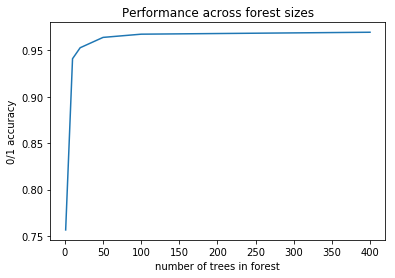

In [11]:
# Now, plot the accuracy as a function of the number of trees in the forest.
plt.plot(num_trees, accs_by_num_trees)
plt.xlabel('number of trees in forest')
plt.ylabel('0/1 accuracy')
plt.title("Performance across forest sizes")

## Evaluating the Holdout Accuracy.
Now, use the optimal setting of the hyperparameters you found above to train a random forest on the entire training set. Report the resulting accuracy of applying this random forest to predict the holdout set instances.

In [12]:
# holdout accuracy
X_holdout = digits['data'][holdout_set_idxs]
y_holdout = digits['target'][holdout_set_idxs]

num_trees = 400
depth = 8

clf = RandomForestClassifier(n_estimators= num_trees, 
                                         max_depth=depth,
                                         random_state=0)

# fit the random forest to the entire training set
clf.fit(X_train, y_train)  
# preidct on the holdout set
y_pred_holdout = clf.predict(X_holdout)

# compute the holdout test accuracy
acc_test = metrics.accuracy_score(y_holdout, y_pred_holdout)
print("holdout set accuracy is {0:.3f}".format(acc_test))

holdout set accuracy is 0.969


TODO: Compare the test set accuracies with the validation set accuracies you found in the cross-validation for this setting of hyperparameters

## Part 4: Investiagating Feature Importances

Lastly, we'll investigate the feature importances associated with each pixel in the images. 

So far, we've been treating the image pixels (8x8 image = 64 pixels) as the feature representation of the image. The random forest model in sklearn calculates these feature importances for you. There, the feature importances are calculated the decrease in gini impurity due to splits on that feature (pixel), averaged across the trees in the forest. 

To visualize these differences effectively, we'll transform the problem into a binary classification problem between two digits. We chose 2 and 7 below, but you'll soon be asked to choose pairs (or more) of digits later on for your own experimentation.

In [13]:
# split training data into just intances of 2's and 7's
y_bin_27 = y_train[np.where((y_train == 2) ^ (y_train == 7))]
X_bin_27 = X_train[np.where((y_train == 2) ^ (y_train == 7))]

In [14]:
# refit using the entire training set
# use the values you found to be the best from kfold validation

num_trees = 400
depth = 8

clf = RandomForestClassifier(n_estimators= num_trees, 
                                         max_depth=depth,
                                         random_state=0)
    
clf.fit(X_bin_27, y_bin_27);

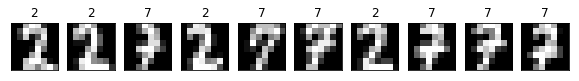

In [15]:
# plot what these images look like
fig, ax = plt.subplots(1,10, figsize=(10,2))
for i in range(10):
    # shape the 64 features back into a 8x8 image
    ax[i].imshow(X_bin_27[i].reshape(8,8), cmap='gray')
    ax[i].set_title('{0}'.format(y_bin_27[i]))
    ax[i].set_xticks([]), ax[i].set_yticks([])

Text(0.5, 1.0, 'feature importances')

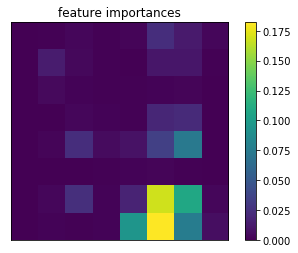

In [16]:
# Plot the feature importances for this binary classification problem
plt.imshow(clf.feature_importances_.reshape(8,8))
plt.colorbar(), plt.xticks([]), plt.yticks([])
plt.title("feature importances")

TODO: where in the image are the feature importances the highest? Where are they the lowest? Give a possible explanation for your findings.

## Todo: repeat the procedure about for 2 new classification problems. 

You may choose binary classification as we did above, but with a different pair of digits, or you may choise classification problems with >2 classes.

For each of the two classification problems you define above, repeat the procedure we did of visualizing your dataset which has just training instances of the classes you choose, fitting a classificaiton forest on these instances, and visualizing the resulting feature importances of each pixel.